Este notebook tem o primeiro contatocom os dados, e nele iremos fazer uma EDA e explorar os dados

# Setting up

## imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pathlib import Path

# current repo path 
repo_path = Path().resolve().parent

spark = SparkSession.builder.appName('Spark Demo').master('local[*]').getOrCreate()


your 131072x1 screen size is bogus. expect trouble
25/05/14 16:02:29 WARN Utils: Your hostname, George-Book3 resolves to a loopback address: 127.0.1.1; using 172.23.250.106 instead (on interface eth0)
25/05/14 16:02:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/14 16:02:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Carregando dados e vendo como estão organizados

In [3]:
offers = spark.read.json((repo_path / 'data' / 'raw' / 'offers.json').as_posix())
transactions = spark.read.json((repo_path / 'data' / 'raw' / 'transactions.json').as_posix())
profiles = spark.read.json((repo_path / 'data' / 'raw' / 'profile.json').as_posix())

## Offers

In [4]:
offers.show(10,False)
offers.printSchema()

+----------------------------+--------------+--------+--------------------------------+---------+-------------+
|channels                    |discount_value|duration|id                              |min_value|offer_type   |
+----------------------------+--------------+--------+--------------------------------+---------+-------------+
|[email, mobile, social]     |10            |7.0     |ae264e3637204a6fb9bb56bc8210ddfd|10       |bogo         |
|[web, email, mobile, social]|10            |5.0     |4d5c57ea9a6940dd891ad53e9dbe8da0|10       |bogo         |
|[web, email, mobile]        |0             |4.0     |3f207df678b143eea3cee63160fa8bed|0        |informational|
|[web, email, mobile]        |5             |7.0     |9b98b8c7a33c4b65b9aebfe6a799e6d9|5        |bogo         |
|[web, email]                |5             |10.0    |0b1e1539f2cc45b7b9fa7c272da2e1d7|20       |discount     |
|[web, email, mobile, social]|3             |7.0     |2298d6c36e964ae4a3e7e9706d1fb8c2|7        |discoun

Offers é uma tabela "direta", com ids unicos e caracteristicas das ofertas

In [60]:
offers.groupBy('discount_value').count().show()

+--------------+-----+
|discount_value|count|
+--------------+-----+
|             0|    2|
|             5|    3|
|            10|    2|
|             3|    1|
|             2|    2|
+--------------+-----+



In [61]:
offers.groupBy('min_value').count().show()

+---------+-----+
|min_value|count|
+---------+-----+
|        0|    2|
|        7|    1|
|        5|    2|
|       10|    4|
|       20|    1|
+---------+-----+



In [62]:
offers.groupBy('offer_type').count().show()

+-------------+-----+
|   offer_type|count|
+-------------+-----+
|     discount|    4|
|informational|    2|
|         bogo|    4|
+-------------+-----+



Não há nada estranho nessa tabela de offers, ela é bem "direta" e descritiva

## Profiles

In [5]:
profiles.show(10,False)
profiles.printSchema()

+---+-----------------+------+--------------------------------+-------------+
|age|credit_card_limit|gender|id                              |registered_on|
+---+-----------------+------+--------------------------------+-------------+
|118|NULL             |NULL  |68be06ca386d4c31939f3a4f0e3dd783|20170212     |
|55 |112000.0         |F     |0610b486422d4921ae7d2bf64640c50b|20170715     |
|118|NULL             |NULL  |38fe809add3b4fcf9315a9694bb96ff5|20180712     |
|75 |100000.0         |F     |78afa995795e4d85b5d9ceeca43f5fef|20170509     |
|118|NULL             |NULL  |a03223e636434f42ac4c3df47e8bac43|20170804     |
|68 |70000.0          |M     |e2127556f4f64592b11af22de27a7932|20180426     |
|118|NULL             |NULL  |8ec6ce2a7e7949b1bf142def7d0e0586|20170925     |
|118|NULL             |NULL  |68617ca6246f4fbc85e91a2a49552598|20171002     |
|65 |53000.0          |M     |389bc3fa690240e798340f5a15918d5c|20180209     |
|118|NULL             |NULL  |8974fc5686fe429db53ddde067b88302|2

Vemos que as datas estão desformatadas, irei transformar a coluna no tipo certo

In [64]:
profiles = profiles.withColumn('registered_on', 
                               F.to_date(F.col('registered_on').cast('string'),'yyyyMMdd')
                               )
profiles.show(3)


+---+-----------------+------+--------------------+-------------+
|age|credit_card_limit|gender|                  id|registered_on|
+---+-----------------+------+--------------------+-------------+
|118|             NULL|  NULL|68be06ca386d4c319...|   2017-02-12|
| 55|         112000.0|     F|0610b486422d4921a...|   2017-07-15|
|118|             NULL|  NULL|38fe809add3b4fcf9...|   2018-07-12|
+---+-----------------+------+--------------------+-------------+
only showing top 3 rows



In [66]:
data_min = profiles.select(F.min('registered_on')).collect()[0][0]
data_max = profiles.select(F.max('registered_on')).collect()[0][0]
print(f"As campanhas vão de {data_min} a {data_max}")


As campanhas vão de 2013-07-29 a 2018-07-26


Vendo se há duplicidade de ids:

In [67]:
profiles.groupBy('id').count().orderBy('count', ascending=False).show(10)

+--------------------+-----+
|                  id|count|
+--------------------+-----+
|c05652fa9d2c4fac9...|    1|
|6be0513109fe4d738...|    1|
|9de54389816342449...|    1|
|f5de20984950433d9...|    1|
|9da3f2339b244229a...|    1|
|fc58860830e648c9b...|    1|
|f608dc84f5f744a88...|    1|
|7a5f837ad609476cb...|    1|
|25540a042d7d4aabb...|    1|
|e1e4b47968ef42509...|    1|
+--------------------+-----+
only showing top 10 rows



Não há

A idade para estranha com vários valores 118, pode ser algum problema na coleta deles?

<Axes: title={'center': 'Histograma da Idade'}, ylabel='Count'>

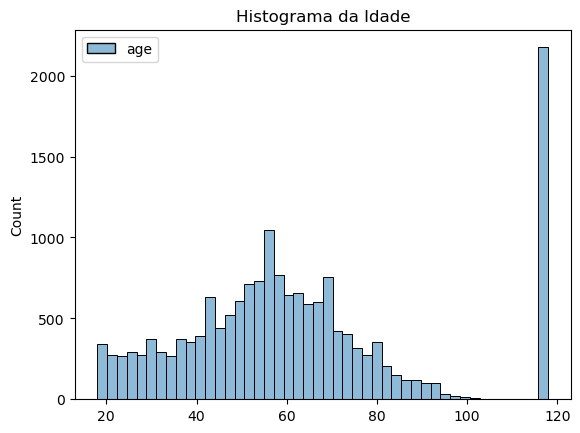

In [68]:
idade = profiles.select('age').toPandas()
plt.title('Histograma da Idade')
sns.histplot(data=idade)


Claramente é um problema nesses dados. Irei considerar idade 118 como nulas para modelagem

In [69]:
profiles.groupBy('gender').count().show()


+------+-----+
|gender|count|
+------+-----+
|     F| 6129|
|  NULL| 2175|
|     M| 8484|
|     O|  212|
+------+-----+



O gênero tem muitos nulos. Isso pode ser tanto um "não quero responder" de algum cadastro ou algum erro sistemático. Irei considerar os nulos como uma categoria própria para não inferir nada nesta questão.

Sobre "O", poderia ser sujeira da base ou significar "Outros". Vou entender como "Outros".

<Axes: title={'center': 'Histograma do limite do cartão'}, ylabel='Count'>

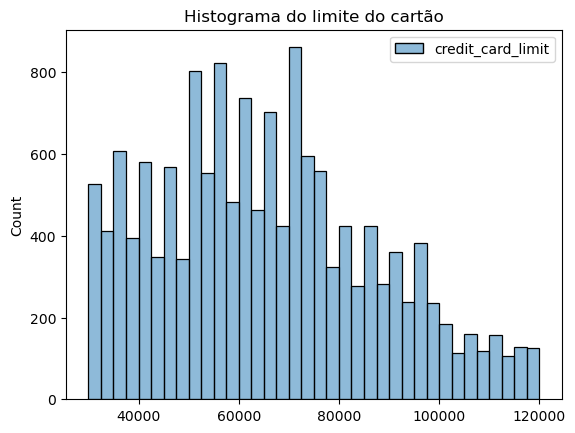

In [72]:
credit_card_limit = profiles.select('credit_card_limit').toPandas()
plt.title('Histograma do limite do cartão')
sns.histplot(data=credit_card_limit)


Dados parecem ok, exceto pela grandeza do limite do cartão rs. Provavelmente está em centavos (40000 = 400 reais)? De qualquer maneira, isso não influencia na modelagem e provavelmente faremos um rescale dos dados.

## Transactions

In [8]:
transactions.show(10,False)
transactions.printSchema()

+--------------------------------+--------------+---------------------+----------------------------------------------------+
|account_id                      |event         |time_since_test_start|value                                               |
+--------------------------------+--------------+---------------------+----------------------------------------------------+
|78afa995795e4d85b5d9ceeca43f5fef|offer received|0.0                  |{NULL, 9b98b8c7a33c4b65b9aebfe6a799e6d9, NULL, NULL}|
|a03223e636434f42ac4c3df47e8bac43|offer received|0.0                  |{NULL, 0b1e1539f2cc45b7b9fa7c272da2e1d7, NULL, NULL}|
|e2127556f4f64592b11af22de27a7932|offer received|0.0                  |{NULL, 2906b810c7d4411798c6938adc9daaa5, NULL, NULL}|
|8ec6ce2a7e7949b1bf142def7d0e0586|offer received|0.0                  |{NULL, fafdcd668e3743c1bb461111dcafc2a4, NULL, NULL}|
|68617ca6246f4fbc85e91a2a49552598|offer received|0.0                  |{NULL, 4d5c57ea9a6940dd891ad53e9dbe8da0, NULL, NULL}|


In [74]:
transactions.orderBy(['account_id', 'time_since_test_start'],ascending=[False, True]).show(20,False)

+--------------------------------+---------------+---------------------+----------------------------------------------------+
|account_id                      |event          |time_since_test_start|value                                               |
+--------------------------------+---------------+---------------------+----------------------------------------------------+
|ffff82501cea40309d5fdd7edcca4a07|offer received |0.0                  |{NULL, fafdcd668e3743c1bb461111dcafc2a4, NULL, NULL}|
|ffff82501cea40309d5fdd7edcca4a07|offer viewed   |0.25                 |{NULL, fafdcd668e3743c1bb461111dcafc2a4, NULL, NULL}|
|ffff82501cea40309d5fdd7edcca4a07|transaction    |2.5                  |{16.06, NULL, NULL, NULL}                           |
|ffff82501cea40309d5fdd7edcca4a07|offer completed|2.5                  |{NULL, NULL, fafdcd668e3743c1bb461111dcafc2a4, 2.0} |
|ffff82501cea40309d5fdd7edcca4a07|transaction    |3.25                 |{7.18, NULL, NULL, NULL}                      

É possível ver que essa tabela é construída via eventos (ou log). Precisaremos ter bastante atenção ao manipular e extrair informações dela levando isso em conta.

In [76]:
transactions.groupBy('event').count().orderBy('count',ascending=False).show(10,False)

+---------------+------+
|event          |count |
+---------------+------+
|transaction    |138953|
|offer received |76277 |
|offer viewed   |57725 |
|offer completed|33579 |
+---------------+------+



In [81]:
transactions = (transactions.withColumn('amount', F.col('value.amount'))
                .withColumn('offer_id1', F.col('value.offer id'))
                .withColumn('offer_id2', F.col('value.offer_id'))
                .withColumn('reward', F.col('value.reward'))
                .drop('value')
)


In [83]:
transactions.show(10)

+--------------------+--------------+---------------------+------+--------------------+---------+------+
|          account_id|         event|time_since_test_start|amount|           offer_id1|offer_id2|reward|
+--------------------+--------------+---------------------+------+--------------------+---------+------+
|78afa995795e4d85b...|offer received|                  0.0|  NULL|9b98b8c7a33c4b65b...|     NULL|  NULL|
|a03223e636434f42a...|offer received|                  0.0|  NULL|0b1e1539f2cc45b7b...|     NULL|  NULL|
|e2127556f4f64592b...|offer received|                  0.0|  NULL|2906b810c7d441179...|     NULL|  NULL|
|8ec6ce2a7e7949b1b...|offer received|                  0.0|  NULL|fafdcd668e3743c1b...|     NULL|  NULL|
|68617ca6246f4fbc8...|offer received|                  0.0|  NULL|4d5c57ea9a6940dd8...|     NULL|  NULL|
|389bc3fa690240e79...|offer received|                  0.0|  NULL|f19421c1d4aa40978...|     NULL|  NULL|
|c4863c7985cf408fa...|offer received|                  

In [85]:
transactions.filter('offer_id1 != offer_id2').count()

0

Como não há dados entre offer id e offer_id nulas, podemos criar um coalesce deles.

(-10.0, 150.0)

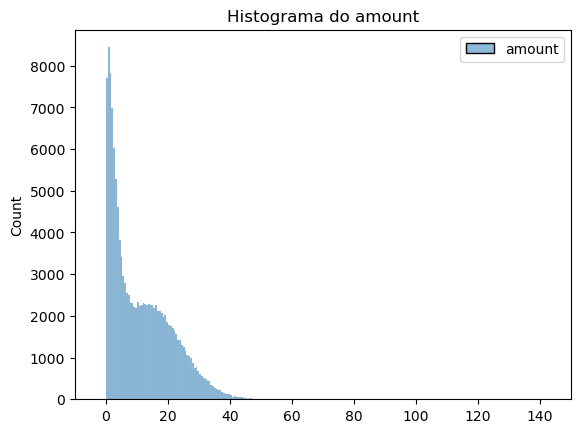

In [89]:
amount = transactions.select('amount').toPandas()
plt.title('Histograma do amount')
sns.histplot(data=amount)
plt.xlim(-10,150)

In [91]:
amount.describe()

,amount
count,138953.000000
mean,12.777356
std,30.250529
min,0.050000
25%,2.780000
50%,8.890000
75%,18.070000
max,1062.280000
